In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input,Conv2D,PReLU,Conv2DTranspose
import pathlib
plt.rcParams['figure.figsize'] = 20,20

2021-09-04 16:14:40.700444: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-04 16:14:40.700474: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [17]:
#constants
#realtime performance
d=32
s=5
m=1
'''
#for better restoration quality:
d=56
s=12
m=4
'''
n=4 # scale factor
channels = 3
TRAIN_IMGS_FOLDER_PATH="datasets/DIV2K/DIV2K_train_HR/DIV2K_train_HR"
VALIDATION_IMGS_FOLDER_PATH="datasets/DIV2K/DIV2K_valid_HR/DIV2K_valid_HR"
EPOCHS = 30
TRAIN_BATCH_SIZE = 50
VAL_BATCH_SIZE = 10
OPTIMIZER = 'adam'
LOSS = tf.keras.losses.MeanSquaredError()


In [3]:
def get_img_paths(path):
    data = pathlib.Path(path)
    all_image_paths = list(data.glob('*'))
    all_image_paths = [str(p) for p in all_image_paths]
    return all_image_paths

In [4]:
def get_min_dim(train_image_paths,validation_image_paths):
    #find min height and width
    min_images_shape_0=float('inf')
    min_images_shape_1=float('inf')
    for path in train_image_paths:
        image=cv2.imread(path)
        min_images_shape_0=min(min_images_shape_0,image.shape[0])
        min_images_shape_1=min(min_images_shape_1,image.shape[1])
    for path in validation_image_paths:
        image=cv2.imread(path)
        min_images_shape_0=min(min_images_shape_0,image.shape[0])
        min_images_shape_1=min(min_images_shape_1,image.shape[1])
    
    return min(min_images_shape_0,min_images_shape_1)

In [5]:
def get_dataset(image_paths,min_dim,n):
    for path in image_paths:
        image=cv2.imread(path.decode())
        #normalize image
        image=image/255.0
        #take a crop of min_dim x min_dim 
        hr_image = image[0:min_dim,0:min_dim]
        #downsample by a factor of 4 to get LR
        lr_image = hr_image.copy()
        lr_image = cv2.resize(lr_image,dsize=(int(648/n),int(648/n)))
        yield lr_image,hr_image
    

In [6]:
def get_model(d,s,m,n,min_dim,channels):
    model= Sequential()
    model.add(Input(shape=(int(min_dim/n),int(min_dim/n),channels)))
    model.add(Conv2D(kernel_size=5,filters=d,padding="same")) #feature extraction
    model.add(PReLU())
    model.add(Conv2D(kernel_size=1,filters=s,padding="same")) #shrinking layer
    model.add(PReLU())
    for i in range(m):
        model.add(Conv2D(kernel_size=3,filters=s,padding="same")) #mapping layer(s)
        model.add(PReLU())
    model.add(Conv2D(kernel_size=1,filters=d,padding="same")) #expansion layer
    model.add(PReLU())
    model.add(Conv2DTranspose(kernel_size=9,filters=channels,strides=n,padding="same")) #DeConv layer
    return model
    

In [7]:
train_image_paths = get_img_paths(TRAIN_IMGS_FOLDER_PATH)
validation_image_paths = get_img_paths(VALIDATION_IMGS_FOLDER_PATH)

In [9]:
min_dim = get_min_dim(train_image_paths,validation_image_paths)

In [10]:
min_dim

648

In [11]:
trainset=tf.data.Dataset.from_generator(generator=get_dataset,args=[train_image_paths,min_dim,n],output_types=(tf.float32,tf.float32))
valset=tf.data.Dataset.from_generator(generator=get_dataset,args=[validation_image_paths,min_dim,n],output_types=(tf.float32,tf.float32))

2021-09-04 16:47:05.479887: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-04 16:47:05.479937: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-04 16:47:05.479982: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (skbubuntu): /proc/driver/nvidia/version does not exist
2021-09-04 16:47:05.480506: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2021-09-04 16:47:17.503079: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


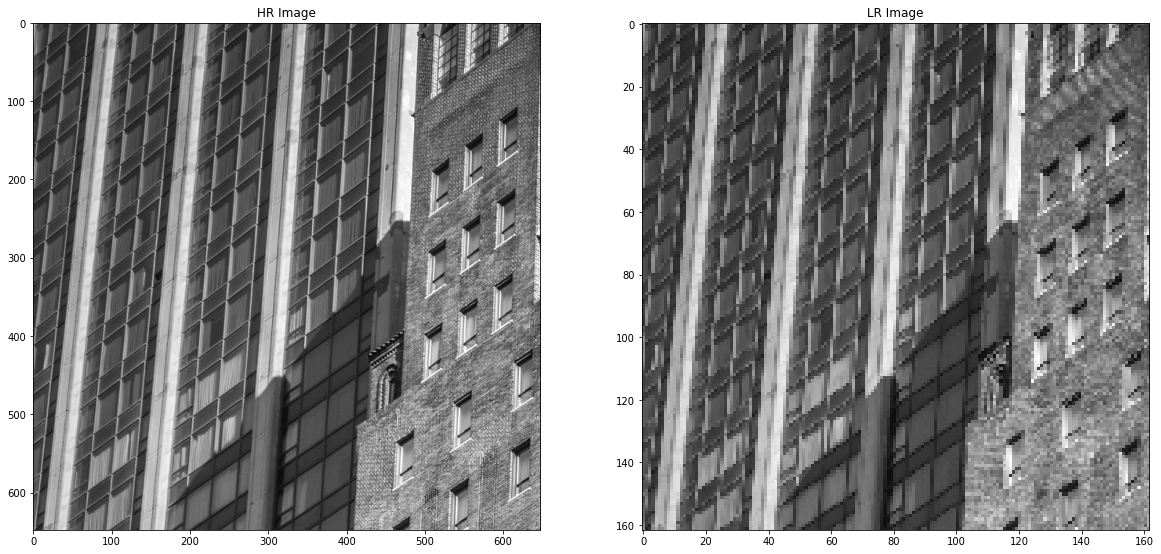

In [12]:
for lr, hr in trainset.take(1):
    fig1=plt.subplot(1,2,1)
    fig1.title.set_text('HR Image')
    plt.imshow(hr)
    fig2=plt.subplot(1,2,2)
    fig2.title.set_text('LR Image')
    plt.imshow(lr)

In [13]:
model = get_model(d,s,m,n,min_dim,channels)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 162, 162, 32)      2432      
_________________________________________________________________
p_re_lu (PReLU)              (None, 162, 162, 32)      839808    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 162, 162, 5)       165       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 162, 162, 5)       131220    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 162, 162, 5)       230       
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 162, 162, 5)       131220    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 162, 162, 32)      1

In [15]:
checkpoint_path = "model_checkpoints/fsrcnn/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [16]:
model.compile(loss=LOSS,optimizer=OPTIMIZER)

In [18]:
dataset = trainset.batch(TRAIN_BATCH_SIZE)
valdataset = valset.batch(VAL_BATCH_SIZE)
history=model.fit(dataset,epochs=EPOCHS,validation_data=valdataset,callbacks=[cp_callback])

Epoch 1/30


2021-09-04 16:49:23.024684: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 251942400 exceeds 10% of free system memory.
2021-09-04 16:49:23.189926: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 167961600 exceeds 10% of free system memory.
2021-09-04 16:49:23.459109: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 167961600 exceeds 10% of free system memory.
2021-09-04 16:49:23.459147: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 167961600 exceeds 10% of free system memory.
2021-09-04 16:49:23.576473: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 167961600 exceeds 10% of free system memory.


16/16 [==============================] - 237s 15s/step - loss: 0.1732 - val_loss: 0.0524

Epoch 00001: saving model to model_checkpoints/fsrcnn/cp.ckpt
Epoch 2/30
16/16 [==============================] - 220s 14s/step - loss: 0.0331 - val_loss: 0.0258

Epoch 00002: saving model to model_checkpoints/fsrcnn/cp.ckpt
Epoch 3/30
16/16 [==============================] - 213s 13s/step - loss: 0.0232 - val_loss: 0.0194

Epoch 00003: saving model to model_checkpoints/fsrcnn/cp.ckpt
Epoch 4/30
16/16 [==============================] - 207s 13s/step - loss: 0.0206 - val_loss: 0.0186

Epoch 00004: saving model to model_checkpoints/fsrcnn/cp.ckpt
Epoch 5/30
16/16 [==============================] - 209s 13s/step - loss: 0.0195 - val_loss: 0.0176

Epoch 00005: saving model to model_checkpoints/fsrcnn/cp.ckpt
Epoch 6/30
16/16 [==============================] - 198s 12s/step - loss: 0.0184 - val_loss: 0.0165

Epoch 00006: saving model to model_checkpoints/fsrcnn/cp.ckpt
Epoch 7/30
16/16 [===============

In [19]:
model.save('models/fsrcnn')

2021-09-04 18:35:22.438491: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/fsrcnn/assets


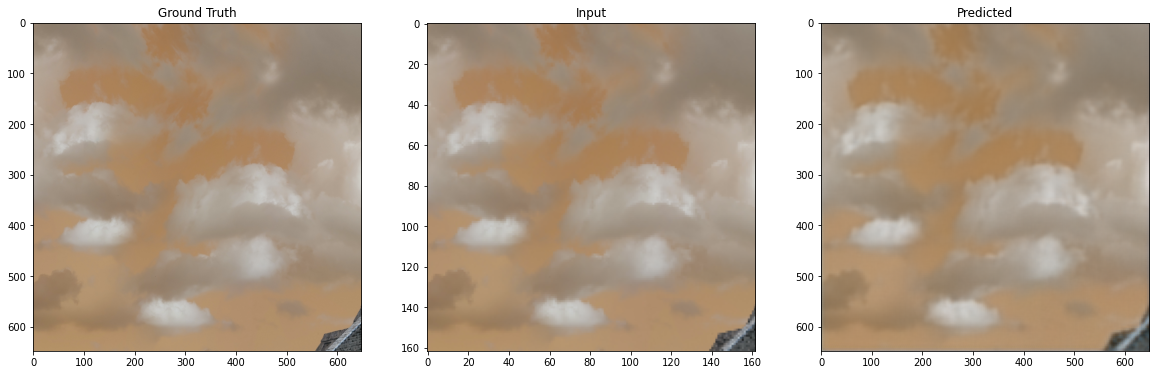

In [26]:
for lr, hr in valset.take(1):
    fig1=plt.subplot(1,3,1)
    fig1.title.set_text('Ground Truth')
    plt.imshow(hr)
    fig2=plt.subplot(1,3,2)
    fig2.title.set_text('Input')
    plt.imshow(lr)
    fig2=plt.subplot(1,3,3)
    fig2.title.set_text('Predicted')
    #reshaped_lr = tf.expand_dims(lr,axis=1)
    predicted_img=model.predict(tf.expand_dims(lr,axis=0))
    plt.imshow(predicted_img[0])

In [ ]:
#todo for better results:
#image augmentation - random crops,flipping, rotation
#train for more epochs
#hyperparamater tuning
#trying a different optimizer
